In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Subset, ChainDataset, DataLoader, random_split
import torch.nn.functional as F

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import wandb

cudnn.benchmark = True

import pandas as pd
import pickle
import math
import random

import HSIC
import matplotlib.pyplot as plt
import numpy as np
import func
import torchy
import cf

from datetime import datetime
from torch.utils.tensorboard import SummaryWriter


from matplotlib import cm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

# %matplotlib widget

In [2]:
a_file = open("PACS.pkl", "rb")
feature_dict = pickle.load(a_file)

# print(feature_dict)

In [3]:
num_classes = 7      # 7 classes for each domain: 'dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person'
classes_names = ['Dog', 'Elephant', 'Giraffe', 'Guitar', 'Horse', 'House', 'Person']
domain_mapping = {'photo':0, 'art_painting':1, 'cartoon':2, 'sketch':3}
batch_size = 64
PATH = 'saved_model.pth'
all_domain_names = ['photo', 'art_painting', 'cartoon', 'sketch']
domain_names = ['photo', 'art_painting', 'cartoon']

criterion = nn.CrossEntropyLoss()


In [4]:
plt.close()

In [7]:
gamma = 1
r = 0
lr=0.001
runs = 10




big_acc = {}
for i in range(len(all_domain_names)):
    big_acc[all_domain_names[i]] = {}
    for j in range(len(all_domain_names)):

        test_predictions_l = []
        test_targets_l = [] 
        
        train_names = all_domain_names[i]
        valid_name = 'split'
        test_name = all_domain_names[j]
        
        big_acc[train_names][test_name] = {'accs':[],'preds':[],'targets':[]}
        if i==j:
            big_acc[train_names][test_name]['accs'] = [0]*runs
            continue


        for run in range(runs):


            train_loader, valid_loader, test_loader  = torchy.get_feature_loaders(feature_dict, 
                                                                                   batch_size,
                                                                                   [train_names],
                                                                                   valid_name,
                                                                                   [test_name],
                                                                                 verbose=False)

            acc_list = []                          
            min_valid_loss = 1000
        
            net = torchy.Net()
            
            optimizer = optim.Adam(net.parameters(), lr=lr)
            min_valid_loss = func.train(net, criterion, optimizer, train_loader,
                                            valid_loader=valid_loader,
                                            epochs=20,
                                            gamma=gamma,
                                            min_valid_loss = min_valid_loss)


            test_preds, test_targets, acc = func.test_model(test_loader, 'saved_model.pth')
            
            
            big_acc[train_names][test_name]['accs'] += [acc]
            big_acc[train_names][test_name]['preds'] += test_preds
            big_acc[train_names][test_name]['targets'] += test_targets

        
        avg_acc = sum(big_acc[train_names][test_name]['accs']) / len(big_acc[train_names][test_name]['accs'])
        print(f'{r} Training: {train_names}, Valid: {valid_name}, Testing: {test_name}, Avg Acc= {avg_acc}%')
        r+=1

            

0 Training: photo, Valid: split, Testing: art_painting, Avg Acc= 66.4%
1 Training: photo, Valid: split, Testing: cartoon, Avg Acc= 60.6%
2 Training: photo, Valid: split, Testing: sketch, Avg Acc= 39.7%
3 Training: art_painting, Valid: split, Testing: photo, Avg Acc= 94.3%
4 Training: art_painting, Valid: split, Testing: cartoon, Avg Acc= 64.1%
5 Training: art_painting, Valid: split, Testing: sketch, Avg Acc= 42.5%
6 Training: cartoon, Valid: split, Testing: photo, Avg Acc= 84.9%
7 Training: cartoon, Valid: split, Testing: art_painting, Avg Acc= 62.4%
8 Training: cartoon, Valid: split, Testing: sketch, Avg Acc= 49.8%
9 Training: sketch, Valid: split, Testing: photo, Avg Acc= 41.9%
10 Training: sketch, Valid: split, Testing: art_painting, Avg Acc= 38.0%
11 Training: sketch, Valid: split, Testing: cartoon, Avg Acc= 50.4%


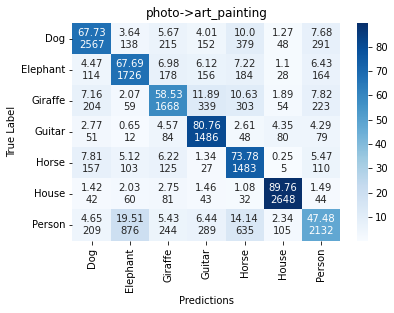

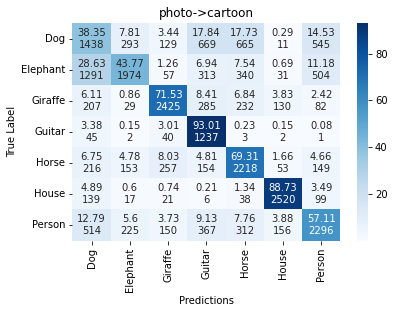

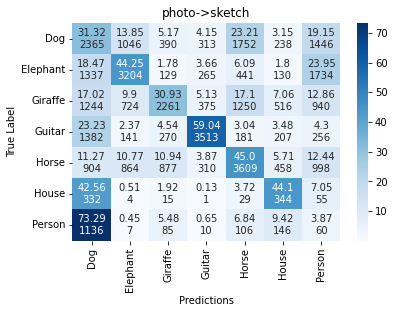

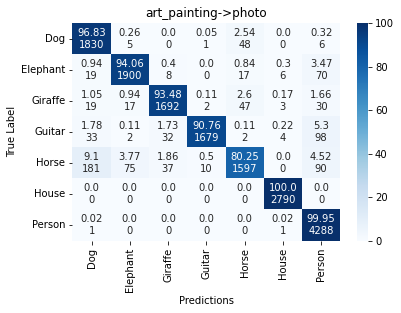

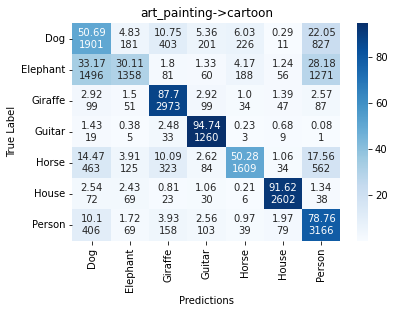

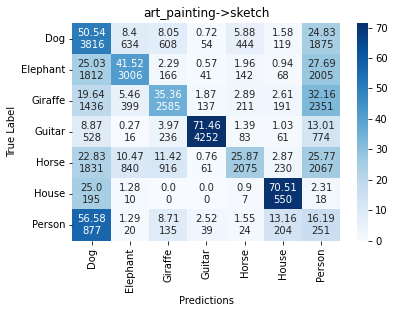

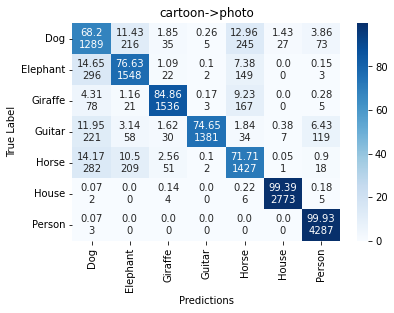

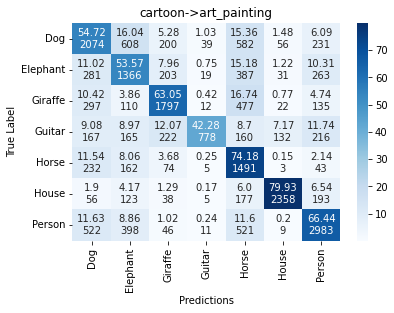

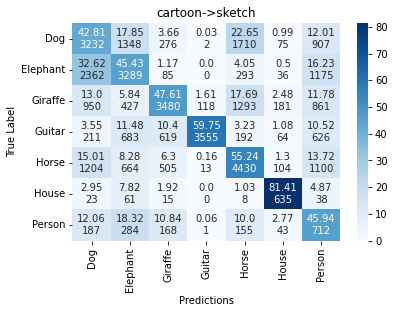

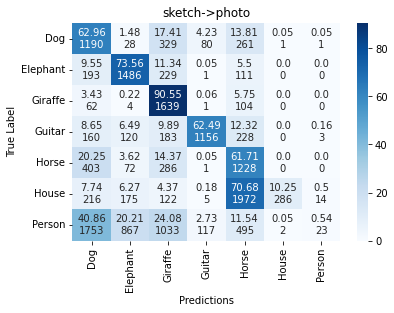

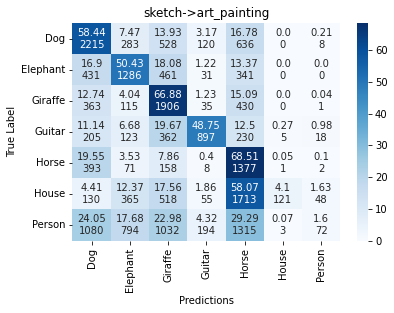

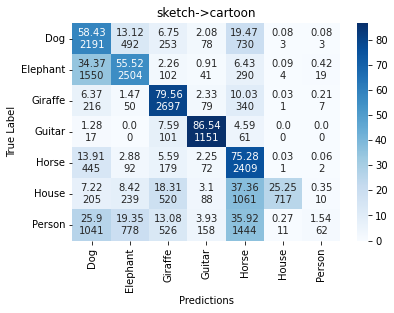

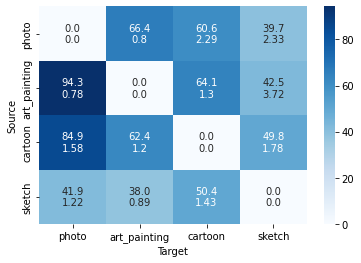

In [9]:
# print(big_acc)
lst = []
most_err = []
for i, name in enumerate(big_acc.keys()):
    lst.append([])
    for name2 in big_acc[name].keys():
        lst[i].append(big_acc[name][name2]['accs'])
        if name == name2:
            continue
        cf = confusion_matrix(np.array(big_acc[name][name2]['targets']), np.array(big_acc[name][name2]['preds'])).transpose()
        sums = np.sum(cf, axis=0)
        cf_pc = (np.divide(cf, sums)*100).transpose().round(2)
        
        
        cf_pc_char = np.char.add( cf_pc.astype(str),'\n')

        cf_char = cf.astype(str).transpose()

        annot = np.asarray(np.char.add(cf_pc_char, cf_char))
        
        plt.figure()

        sns.heatmap(cf_pc,annot=annot, fmt="",cmap='Blues',cbar=True,xticklabels=classes_names,yticklabels=classes_names)
        plt.ylabel('True Label')
        plt.xlabel('Predictions')
                          
        plt.title(f'{name}->{name2}')
        plt.show()
#         ind = (-cf_pc).argsort(axis=-1)[:, 1:2] 
#         print(np.asarray(classes_names)[ind])
#         print(ind)
        
cf = np.asarray(lst).mean(axis=2).round(2)
cf_std = np.asarray(lst).std(axis=2).round(2)
cf_std_char = np.char.add('\n', cf_std.astype(str))
cf_char = cf.astype(str)
annot = np.asarray(np.char.add(cf_char,cf_std_char))
plt.figure()
sns.heatmap(cf,annot=annot, fmt="",cmap='Blues',cbar=True,xticklabels=all_domain_names,yticklabels=all_domain_names)
plt.ylabel('Source')
plt.xlabel('Target')
plt.show()


In [ ]:
        cf = confusion_matrix(np.array(test_targets_l), np.array(test_predictions_l)).transpose()
        sums = np.sum(cf, axis=0)

        cf_pc = (np.divide(cf, sums)*100).transpose().round(2)
        cf_pc_char = np.char.add('\n', cf_pc.astype(str))

        cf_char = cf.astype(str)

        annot = np.asarray(np.char.add(cf_char,cf_pc_char))
        
        plt.figure()

        sns.heatmap(cf,annot=annot, fmt="",cmap='Blues',cbar=True,xticklabels=classes_names,yticklabels=classes_names)
        plt.ylabel('True Label')
        plt.xlabel('Predictions')
                          
        plt.title(f'{train_names}->{test_name}')
        plt.show()

In [ ]:
PATH = 'saved_model.pth'
test_net = torchy.Net()
test_net.load_state_dict(torch.load(PATH))

test_net.eval()

big_loader, _, _  = torchy.get_feature_loaders(feature_dict, 
                                                   batch_size,
                                                   train_names=domain_names)


test_imgs = torch.zeros((0, 512), dtype=torch.float32)
test_predictions = []
test_targets = []
test_domains = []
test_embeddings = torch.zeros((0, 7), dtype=torch.float32)

for loader in [big_loader]:
    for X,y in loader:
        for d, x in enumerate(X):
        
            embeddings, logits = test_net(x)
            preds = torch.argmax(logits, dim=1)
            test_predictions.extend(preds.detach().cpu().tolist())
            test_targets.extend(y.detach().cpu().tolist())
            test_domains+=[d]*len(x)
            test_embeddings = torch.cat((test_embeddings, logits.detach().cpu()), 0)
            test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)

test_imgs = np.array(test_imgs)
# test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)
test_domains = np.array(test_domains)
test_predictions = np.array(test_predictions)



In [ ]:
print(len(big_loader))
print(len(test_targets))
print(test_predictions[:100])
# print(np.count_nonzero(test_domains!=2))
print(len(test_domains))

In [ ]:

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')


In [ ]:
# #{'photo':0, 'art_painting':1, 'cartoon':2, 'sketch':3}

# fig, axs = plt.subplots(2, 2)
# fig.suptitle(f'Trained on {train_names}, with hsic: {hsic_name!=None}', fontsize=16)
# for i, d_n in enumerate(domain_names):
#     ax = axs[i%2, math.floor(i/2)]
#     ax.set_title(d_n)
#     num_categories = 7
#     for lab in range(num_categories):        
#         ax.scatter(tsne_proj[(test_targets==lab) & (test_domains==i), 0],
#                    tsne_proj[(test_targets==lab) & (test_domains==i),1],
#                    c=np.array(cmap(lab)).reshape(1,4),
#                    label = classes_names[lab],
#                    alpha=0.5)
    
# ax.legend(fontsize='small', markerscale=2, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()


In [ ]:
# from sklearn.metrics import confusion_matrix
# import cf

# conf = confusion_matrix(test_targets, test_predictions)
# cf.make_confusion_matrix(conf,
#                           group_names=None,
#                           categories=classes_names,
#                           count=True,
#                           percent=True,
#                           cbar=True,
#                           xyticks=True,
#                           xyplotlabels=True,
#                           sum_stats=True,
#                           figsize=None,
#                           cmap='Blues',
#                           title=None)

In [ ]:
y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
cof = confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"]).transpose()
print(cof)

sums = np.sum(cof, axis=0)
print(sums)
cof_pc = np.divide(cof, sums)*100

In [ ]:
print(cof)
print(cof_pc.transpose())


In [ ]:
tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
cmap = cm.get_cmap('tab20')
num_categories = 7
for lab in range(num_categories):
    indices = test_predictions == lab
    ax.scatter(tsne_proj[indices, 0],
               tsne_proj[indices, 1],
               tsne_proj[indices, 2],
               c=np.array(cmap(lab)).reshape(1, 4),
               label=lab,
               alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()